# Import Packages

In [37]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [3]:
import mysql.connector
from mysql.connector import errorcode
import config

# Load FLIGHTS data from MySQL

In [4]:
# Connect to database
dbname = 'FLIGHTS'
cnx = mysql.connector .connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname
)
cursor = cnx.cursor()

In [5]:
# Get FLIGHTS data from MySQL
cursor.execute('''SELECT flight_id, date, origin, origin_city, dest, dest_city, dep_delay, arr_delay FROM FLIGHTS.FLIGHTS''')
flights_data = cursor.fetchall()
flights_df = pd.DataFrame(flights_data)

# Get column names for flights dataframe
field_names = [i[0] for i in cursor.description]
flights_df.columns = field_names

In [6]:
flights_df.head()

,flight_id,date,origin,origin_city,dest,dest_city,dep_delay,arr_delay
0,1,2013-07-01,LAX,"Los Angeles, CA",JFK,"New York, NY",-4.0,19.0
1,2,2013-07-01,LAX,"Los Angeles, CA",JFK,"New York, NY",257.0,278.0
2,3,2013-07-01,LAX,"Los Angeles, CA",JFK,"New York, NY",110.0,139.0
3,4,2013-07-01,LAX,"Los Angeles, CA",JFK,"New York, NY",25.0,39.0
4,5,2013-07-01,LAX,"Los Angeles, CA",JFK,"New York, NY",-1.0,12.0


In [7]:
flights_df.dropna(inplace = True)
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52198 entries, 0 to 52636
Data columns (total 8 columns):
flight_id      52198 non-null int64
date           52198 non-null object
origin         52198 non-null object
origin_city    52198 non-null object
dest           52198 non-null object
dest_city      52198 non-null object
dep_delay      52198 non-null float64
arr_delay      52198 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 3.6+ MB


In [8]:
flights_df['origin'].value_counts()

JFK    16396
LAX    15945
MIA    13401
LGA     6456
Name: origin, dtype: int64

In [9]:
# Group data by origin city
jfk = flights_df[flights_df['origin'] == 'JFK']
lga = flights_df[flights_df['origin'] == 'LGA']
lax = flights_df[flights_df['origin'] == 'LAX']
mia = flights_df[flights_df['origin'] == 'MIA']

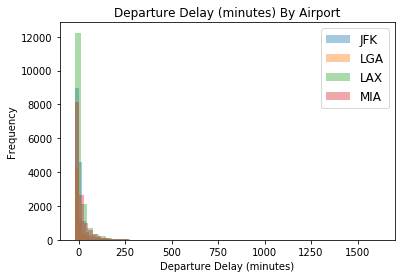

In [10]:
sns.distplot(jfk['dep_delay'], kde = False, label = 'JFK');
sns.distplot(lga['dep_delay'], kde = False, label = 'LGA');
sns.distplot(lax['dep_delay'], kde = False, label = 'LAX');
sns.distplot(mia['dep_delay'], kde = False, label = 'MIA');
plt.legend(prop={'size': 12});
plt.title('Departure Delay (minutes) By Airport');
plt.xlabel('Departure Delay (minutes)');
plt.ylabel('Frequency');
plt.savefig('dep_delay_airport.jpg')

In [11]:
# from datetime import datetime
# flights_df['datetime'] = [datetime.strptime(date, '%Y-%m-%d') for date in flights_df['date']]
# flights_201307 = flights_df[flights_df['date'].str.contains('2013-07')]
# chart = sns.lineplot(x = 'date', y = 'dep_delay', data = flights_201307, hue = 'origin');

# chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment = 'right');

In [12]:
# Calculate standard deviation of departure delay by origin city
count_airport = pd.DataFrame(flights_df.groupby('origin').size())
count_airport['dep_delay'] = pd.DataFrame(flights_df.groupby('origin')['dep_delay'].std())
count_airport.columns = ['# of Flights', 'Standard Deviation of Departure Delay (Minutes)']
count_airport

,# of Flights,Standard Deviation of Departure Delay (Minutes)
origin,,
JFK,16396,44.162959
LAX,15945,48.941694
LGA,6456,44.138704
MIA,13401,54.746669


# ANOVA Departure Delay ~ Origin

$H_0$ : $D_{JFK}$ = $D_{LGA}$ = $D_{LAX}$ = $D_{MIA}$

$H_A$ : $H_0$ is false

In [13]:
anova_origin_city = ols('dep_delay~origin', data = flights_df).fit()
anova_origin_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dep_delay   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     57.80
Date:                Fri, 15 Nov 2019   Prob (F-statistic):           2.70e-37
Time:                        09:09:39   Log-Likelihood:            -2.7670e+05
No. Observations:               52198   AIC:                         5.534e+05
Df Residuals:                   52194   BIC:                         5.534e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.2493      0.379     32.323      0.000      11.507      12.992
origin[T.LAX]     1.7587      0.540      3.259      0.001       0.701       2.817
origin[T.LGA]    -0.7802      0.713     -1.094      0.274      -2.178       0.617
origin[T.MIA]     6.6772      0.565     11.816      0.000       5.570       7.785
==============================================================================
Omnibus:                    71709.208   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29729990.411
Skew:                           7.841   Prob(JB):                         0.00
Kurtosis:                     118.860   Cond. No.                         4.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
anova_table = sm.stats.anova_lm(anova_origin_city, type=2)

In [15]:
pd.DataFrame(anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
origin,3.0,4.083266e+05,136108.855323,57.801272,2.700782e-37
Residual,52194.0,1.229050e+08,2354.772681,NaN,NaN


In [16]:
esq_sm = anova_table['sum_sq'][0]/(anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
anova_table['EtaSq'] = [esq_sm, 'NaN']
anova_table.index = ['Departing Airport', 'Residual']
anova_table.columns = ['Degrees of Freedom', 'Sums of Squares', 'Mean Squares', 'F-Statistic', 'p-value', 'Effect Size']
pd.DataFrame(anova_table)

,Degrees of Freedom,Sums of Squares,Mean Squares,F-Statistic,p-value,Effect Size
Departing Airport,3.0,4.083266e+05,136108.855323,57.801272,2.700782e-37,0.00331129
Residual,52194.0,1.229050e+08,2354.772681,NaN,NaN,NaN


# Post Hoc ANOVA

In [60]:
import statsmodels

In [61]:
mc = statsmodels.stats.multicomp.MultiComparison(flights_df['dep_delay'], flights_df['origin'])
result = mc.tukeyhsd()

result_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
print(result)
print(mc.groupsunique)
result_df.columns = ['Group 1', 'Group 2', 'Mean Difference', 'p-adj', '95% CI Lower-Bound', '95% CI Upper-Bound', 'Reject Null']
result_df

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   JFK    LAX   1.7587 0.0062  0.3721  3.1453   True
   JFK    LGA  -0.7802  0.671 -2.6119  1.0516  False
   JFK    MIA   6.6772  0.001  5.2255   8.129   True
   LAX    LGA  -2.5389 0.0022 -4.3779 -0.6998   True
   LAX    MIA   4.9185  0.001  3.4575  6.3795   True
   LGA    MIA   7.4574  0.001  5.5687  9.3461   True
----------------------------------------------------
['JFK' 'LAX' 'LGA' 'MIA']


,Group 1,Group 2,Mean Difference,p-adj,95% CI Lower-Bound,95% CI Upper-Bound,Reject Null
0,JFK,LAX,1.7587,0.0062,0.3721,3.1453,True
1,JFK,LGA,-0.7802,0.6710,-2.6119,1.0516,False
2,JFK,MIA,6.6772,0.0010,5.2255,8.1290,True
3,LAX,LGA,-2.5389,0.0022,-4.3779,-0.6998,True
4,LAX,MIA,4.9185,0.0010,3.4575,6.3795,True
5,LGA,MIA,7.4574,0.0010,5.5687,9.3461,True


# Load Weather Data

In [19]:
dbname = 'FLIGHTS'
cnx = mysql.connector .connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname
)
cursor = cnx.cursor()

In [20]:
cursor.execute('''SELECT date, city_name, precip_intens, precip_type, max_temp, min_temp, visibility, wind_gust FROM FLIGHTS.WEATHER''')
weather_data = cursor.fetchall()
weather_df = pd.DataFrame(weather_data)
weather_df.shape
field_names = [i[0] for i in cursor.description]
weather_df.columns = field_names

In [21]:
weather_df.head()

,date,city_name,precip_intens,precip_type,max_temp,min_temp,visibility,wind_gust
0,2013-07-01,"Los Angeles, CA",0.0000,None,96.03,67.18,9.731,10.36
1,2013-07-01,"Miami, FL",0.0010,rain,88.47,78.40,9.997,18.00
2,2013-07-01,"New York, NY",0.0324,rain,76.39,72.88,5.383,9.41
3,2013-07-02,"Los Angeles, CA",0.0000,None,85.97,65.60,8.973,12.53
4,2013-07-02,"Miami, FL",0.0027,rain,85.29,76.65,9.923,15.46


# Merge Flight and Weather Data

In [22]:
flight_weather = pd.merge(flights_df, weather_df,  how = 'left', left_on=['date','origin_city'], right_on = ['date','city_name'])

In [23]:
flight_weather.head()

,flight_id,date,origin,origin_city,dest,dest_city,dep_delay,arr_delay,city_name,precip_intens,precip_type,max_temp,min_temp,visibility,wind_gust
0,1,2013-07-01,LAX,"Los Angeles, CA",JFK,"New York, NY",-4.0,19.0,"Los Angeles, CA",0.0,None,96.03,67.18,9.731,10.36
1,2,2013-07-01,LAX,"Los Angeles, CA",JFK,"New York, NY",257.0,278.0,"Los Angeles, CA",0.0,None,96.03,67.18,9.731,10.36
2,3,2013-07-01,LAX,"Los Angeles, CA",JFK,"New York, NY",110.0,139.0,"Los Angeles, CA",0.0,None,96.03,67.18,9.731,10.36
3,4,2013-07-01,LAX,"Los Angeles, CA",JFK,"New York, NY",25.0,39.0,"Los Angeles, CA",0.0,None,96.03,67.18,9.731,10.36
4,5,2013-07-01,LAX,"Los Angeles, CA",JFK,"New York, NY",-1.0,12.0,"Los Angeles, CA",0.0,None,96.03,67.18,9.731,10.36


# Clean Precipitation Type

In [24]:
import matplotlib.pyplot as plt

In [25]:
flight_weather['precip_type'].value_counts()

rain     17793
snow       578
sleet       66
Name: precip_type, dtype: int64

In [26]:
# Check that missing preciptation type is because precipitation intensity was 0
weather_none = flight_weather[flight_weather['precip_type'].isnull()]
print(len(weather_none))
weather_precip_0 = flight_weather[(flight_weather['precip_intens'] == 0) & (flight_weather['precip_type'].isnull())]
print(len(weather_precip_0))

33761
33761


In [27]:
flight_weather_precip = flight_weather.fillna(value = {'precip_type': 'No Precipitation'})

In [28]:
# Calculate standard deviation of departure delay by origin city
count_precip = pd.DataFrame(flight_weather_precip.groupby('precip_type').size())
count_precip['dep_delay'] = pd.DataFrame(flight_weather_precip.groupby('precip_type')['dep_delay'].std())
count_precip.columns = ['# of Flights Affected by Precipitation Type', 'Standard Deviation of Departure Delay (Minutes)']
count_precip

,# of Flights Affected by Precipitation Type,Standard Deviation of Departure Delay (Minutes)
precip_type,,
No Precipitation,33761,42.921722
rain,17793,57.722558
sleet,66,19.241085
snow,578,42.382735


In [29]:
flight_weather_twoway = flight_weather_precip[flight_weather_precip['precip_type'].isin(['No Precipitation', 'rain'])]

# ANOVA Departure Delay Time ~ Precipitation Type

$H_0$ : $D_{no rain}$ = $D_{rain}$ = $D_{sleet}$ = $D_{snow}$
    
$H_A$ : $H_0$ is false

In [38]:
formula = 'dep_delay~precip_type'
anova_precip = ols(formula, data = flight_weather_precip).fit()
print(anova_precip.summary())
anova_table1 = sm.stats.anova_lm(anova_precip, typ=2)

                            OLS Regression Results                            
Dep. Variable:              dep_delay   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     110.3
Date:                Fri, 15 Nov 2019   Prob (F-statistic):           3.64e-71
Time:                        09:20:01   Log-Likelihood:            -2.7662e+05
No. Observations:               52198   AIC:                         5.533e+05
Df Residuals:                   52194   BIC:                         5.533e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               11.5750 

In [39]:
esq_sm1 = anova_table1['sum_sq'][0]/(anova_table1['sum_sq'][0] + anova_table1['sum_sq'][1])
anova_table1['EtaSq'] = [esq_sm1, 'NaN']
anova_table1.index = ['Precipitation Type', 'Residual']
anova_table1.columns = ['Sums of Squares', 'Degrees of Freedom', 'F-Statistic', 'p-value', 'Effect Size']
pd.DataFrame(anova_table1)

,Sums of Squares,Degrees of Freedom,F-Statistic,p-value,Effect Size
Precipitation Type,7.765748e+05,3.0,110.259553,3.635997e-71,0.00629757
Residual,1.225368e+08,52194.0,NaN,NaN,NaN


# Post hoc ANOVA

In [68]:
mc = statsmodels.stats.multicomp.MultiComparison(flight_weather_precip['dep_delay'], flight_weather_precip['precip_type'])
result = mc.tukeyhsd()
result_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
print(result)
print(mc.groupsunique)

result_df.columns = ['Group 1', 'Group 2', 'Mean Difference', 'p-adj', '95% CI Lower-Bound', '95% CI Upper-Bound', 'Reject Null']
result_df

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
     group1      group2 meandiff p-adj   lower    upper  reject
---------------------------------------------------------------
No Precipitation   rain   8.1108  0.001   6.9576   9.264   True
No Precipitation  sleet  -4.0144    0.9  -19.352 11.3231  False
No Precipitation   snow   6.2865 0.0107   1.0647 11.5084   True
            rain  sleet -12.1252 0.1772 -27.4762  3.2257  False
            rain   snow  -1.8242 0.7851  -7.0854  3.4369  False
           sleet   snow   10.301 0.3588  -5.8728 26.4747  False
---------------------------------------------------------------
['No Precipitation' 'rain' 'sleet' 'snow']


,Group 1,Group 2,Mean Difference,p-adj,95% CI Lower-Bound,95% CI Upper-Bound,Reject Null
0,No Precipitation,rain,8.1108,0.0010,6.9576,9.2640,True
1,No Precipitation,sleet,-4.0144,0.9000,-19.3520,11.3231,False
2,No Precipitation,snow,6.2865,0.0107,1.0647,11.5084,True
3,rain,sleet,-12.1252,0.1772,-27.4762,3.2257,False
4,rain,snow,-1.8242,0.7851,-7.0854,3.4369,False
5,sleet,snow,10.3010,0.3588,-5.8728,26.4747,False


# Two Sample T-test: Departure Delay ~ Precipitation Type

$H_0$ : $D_{no rain}$ = $D_{rain}$
    
$H_A$ : $H_0$ is false

In [48]:
# Subset for rain or no precipitation
rain = flight_weather_twoway[flight_weather_twoway['precip_type'] == 'rain']
no_rain = flight_weather_twoway[flight_weather_twoway['precip_type'] == 'No Precipitation']

# Print mean departure delay (minutes) for when it's raining and not raining
# Print degrees of freedom
rain_mu = np.mean(rain['dep_delay'])
no_rain_mu = np.mean(no_rain['dep_delay'])
df = len(rain['dep_delay']) + len(no_rain['dep_delay']) - 2

t, p = ttest_ind(rain['dep_delay'], no_rain['dep_delay'], equal_var = False)

In [128]:
ttest = pd.DataFrame([[round(rain_mu, 4), round(no_rain_mu, 4), round(rain_mu, 4) - round(no_rain_mu, 4), df, round(t, 4), p]], )
ttest.columns = ['Mean Dep. Delay (Rain)', 'Mean Dep. Delay (No Precip.)', 'Mean Diff.', 'Degrees of Freedom', 't-statistic', 'p-value']
ttest

,Mean Dep. Delay (Rain),Mean Dep. Delay (No Precip.),Mean Diff.,Degrees of Freedom,t-statistic,p-value
0,19.6858,11.575,8.1108,51552,16.4934,7.851862e-61


# ANOVA Departure Delay ~ Origin + Precipitation Type

$H_0$ : $D_{JFK}$ = $D_{LGA}$ = $D_{LAX}$ = $D_{MIA}$

$H_A$ : $H_0$ is false

$H_0$ : $D_{no rain}$ = $D_{rain}$

$H_A$ : $H_0$ is false

$H_0$ : There is no interaction between origin airport and rain

$H_A$ : $H_0$ is false

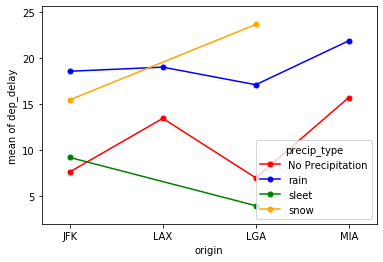

In [133]:
fig = interaction_plot(x = flight_weather_precip.origin, 
                       trace = flight_weather_precip.precip_type, 
                       response = flight_weather_precip.dep_delay, 
                       colors = ['red', 'blue', 'green', 'orange'], ms=10)

In [48]:
flight_weather_precip['precip_type'].value_counts()

No Precipitation    33761
rain                17793
snow                  578
sleet                  66
Name: precip_type, dtype: int64

In [49]:
flight_weather_twoway['precip_type'].value_counts()

No Precipitation    33761
rain                17793
Name: precip_type, dtype: int64

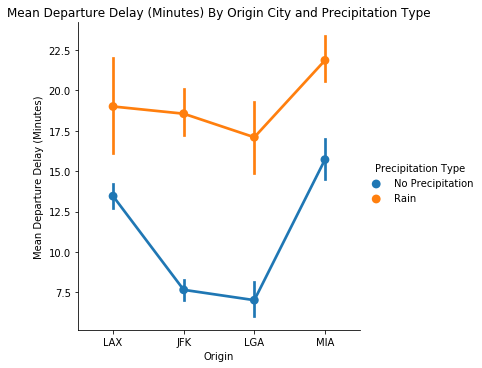

In [136]:
interaction_plot = sns.catplot(x = 'origin', y = 'dep_delay', 
                               hue = 'precip_type', kind = 'point', 
                               data = flight_weather_twoway);
interaction_plot.set(xlabel = 'Origin', ylabel = 'Mean Departure Delay (Minutes)', 
                     title = 'Mean Departure Delay (Minutes) By Origin City and Precipitation Type')
interaction_plot._legend.set_title('Precipitation Type')
for cat, label in zip(interaction_plot._legend.texts,('No Precipitation', 'Rain')):
    cat.set_text(label)
interaction_plot.savefig('departure_delay_airport.jpg')

In [105]:
formula = 'dep_delay~C(origin) + C(precip_type) + C(origin):C(precip_type)'
anova_origin_city = ols(formula, data = flight_weather_twoway).fit()
anova_table2 = sm.stats.anova_lm(anova_origin_city, typ=2)

In [106]:
anova_origin_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dep_delay   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     73.38
Date:                Fri, 15 Nov 2019   Prob (F-statistic):          3.27e-106
Time:                        09:58:01   Log-Likelihood:            -2.7321e+05
No. Observations:               51554   AIC:                         5.464e+05
Df Residuals:                   51546   BIC:                         5.465e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   7.6551      0.502     15.261      0.000       6.672       8.638
C(origin)[T.LAX]                            5.7982      0.644      8.998      0.000       4.535       7.061
C(origin)[T.LGA]                           -0.6399      0.943     -0.679      0.497      -2.487       1.208
C(origin)[T.MIA]                            8.0569      0.787     10.240      0.000       6.515       9.599
C(precip_type)[T.rain]                     10.9019      0.779     13.995      0.000       9.375      12.429
C(origin)[T.LAX]:C(precip_type)[T.rain]    -5.3527      1.498     -3.574      0.000      -8.288      -2.417
C(origin)[T.LGA]:C(precip_type)[T.rain]    -0.8186      1.468     -0.558      0.577      -3.696       2.058
C(origin)[T.MIA]:C(precip_type)[T.rain]    -4.7565      1.144     -4.157      0.000      -6.999      -2.514
==============================================================================
Omnibus:                    70960.005   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29952051.204
Skew:                           7.863   Prob(JB):                         0.00
Kurtosis:                     120.031   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

# def omega_squared(aov):
#     mse = aov['sum_sq'][-1]/aov['df'][-1]
#     aov['omega_sq'] = 'NaN'
#     aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
#     return aov

In [108]:
#anova_table1.index = ['Precipitation Type', 'Residual']
#anova_table1.columns = ['Sums of Squares', 'Degrees of Freedom', 'F-Statistic', 'p-value', 'Effect Size']
#pd.DataFrame(anova_table1)

eta_squared(anova_table2)
# omega_squared(anova_table2)
anova_twoway_df = pd.DataFrame(anova_table2.round(4))
anova_twoway_df.index = ['Origin Airport', 'Precipitation Type', 'Interaction Term', 'Residual']
anova_twoway_df.columns = ['Sums of Squares', 'Degrees of Freedom', 'F-Statistic', 'p-value', 'Eta Sq.']
anova_twoway_df

,Sums of Squares,Degrees of Freedom,F-Statistic,p-value,Eta Sq.
Origin Airport,3.824059e+05,3.0,54.2852,0.0,0.0031
Precipitation Type,7.274663e+05,1.0,309.8067,0.0,0.0060
Interaction Term,5.713751e+04,3.0,8.1111,0.0,0.0005
Residual,1.210367e+08,51546.0,NaN,NaN,NaN


In [109]:
cursor.close()
cnx.close()

# Post hoc ANOVA

In [124]:
mc = statsmodels.stats.multicomp.MultiComparison(flight_weather_twoway['dep_delay'], flight_weather_twoway['origin'])
result = mc.tukeyhsd()
result_df2 = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
result_df2.columns = ['Group 1', 'Group 2', 'Mean Difference', 'p-adj', '95% CI Lower-Bound', '95% CI Upper-Bound', 'Reject Null']
result_df2

,Group 1,Group 2,Mean Difference,p-adj,95% CI Lower-Bound,95% CI Upper-Bound,Reject Null
0,JFK,LAX,1.8323,0.0043,0.4336,3.2311,True
1,JFK,LGA,-1.0113,0.5021,-2.8735,0.8510,False
2,JFK,MIA,6.7509,0.0010,5.2872,8.2145,True
3,LAX,LGA,-2.8436,0.0010,-4.7058,-0.9814,True
4,LAX,MIA,4.9185,0.0010,3.4549,6.3821,True
5,LGA,MIA,7.7622,0.0010,5.8507,9.6736,True
